In [6]:
import os
import glob
import numpy as np
import xarray as xr
from scipy.ndimage import rotate
from scipy.integrate import cumtrapz

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
matplotlib.rcParams.update({'font.size':15})
import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/global/cscratch1/sd/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)
    
from tools.e5tools import *;from tools.generalTools import *
from orographicConvectionTheory.orographicConvectionTheory import *
from orographicPrecipitation.observationsAndERA5.mountainUtils import *; from tools.generalTools import *; from tools.BLtools import *
from tools.generalTools import qsat
km_per_degreelat = 6370*np.pi/180
mnths=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

xr.set_options(display_style='text') 

# Data, functions

In [13]:
from scipy import special
def linregress_xr_2(x,y,dim='time'):
    nt = len(x[dim])
    assert nt==len(y[dim])
    ssxm = nt*x.var(dim=dim)
    ssym = nt*y.var(dim=dim)
    ssxym = nt*xr.cov(x,y,dim=dim)       
    r = np.maximum(np.minimum(ssxym / np.sqrt(ssxm * ssym),1.),-1)
    slope = ssxym / ssxm
    
    df = nt - 2  # Number of degrees of freedom
    TINY = 1.0e-20
    t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
    
    pval = special.stdtr(df, -np.abs(t))*2 * x.isel({dim:0})**0
    
    return xr.merge([slope.rename('slope'),(r**2).rename('rsquared'),pval.rename('pvalue')])

def fdr(pvalues,alpha):
    sortidx = np.argsort(pvalues)
    psorted = pvalues[sortidx]
    psorted[np.isnan(psorted)]=1
    nval = len(pvalues)
    ifdr = np.argmax((psorted < alpha*np.arange(1,nval+1)/nval)[::-1])
    if ifdr == 0 and psorted[-1]>= alpha:
        ifdr=nval-1
    ifdr = nval - ifdr - 1
    return sortidx[:ifdr]

def fdr_xr_2d(pvalues,alpha):
    pvalues=np.array(pvalues)
    assert len(pvalues.shape)==2
    ntot = pvalues.shape[0]*pvalues.shape[1]
    idxs_1d = fdr(pvalues.reshape(-1),alpha)
    flags = np.zeros(ntot)
    flags[idxs_1d] = 1
    return flags.reshape(pvalues.shape)*pvalues**0

def sel_summer(var):
    return var.sel(time = ((var['time.month']>=7)&(var['time.month']<=9)))

In [2]:
# Monthly data loading
orogm=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81
landmask=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM.isel(time=0)


gpm_pr = xr.open_dataarray('/global/cscratch1/sd/qnicolas/temp/GPM-IMERG.monthly.2001-2020.nc')    
gpm_pr_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/GPM-IMERG-seasonalmean-200101-202012.nc")

era5100u_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_246_100u.2001-2020.nc")
era5100v_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_247_100v.2001-2020.nc")
era5100u_monthly=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.monthly.228_246_100u.2001-2020.nc")
era5100v_monthly=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.monthly.228_247_100v.2001-2020.nc")

era5sst_monthly=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.monthly.128_034_sstk.2001-2020.nc")
era5psfc_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.128_134_sp.2001-2018.nc")


## Data loading - 2001-2020

In [3]:
#mountaintop=1700. # abscissa of mountain top within rotated frame
SMO = MountainRangeCustom("smo"      ,[230,280,5,45]   ,"Sierra Madre Occidental",60 ,[7,8,9]  ,[254, 21, 249, 27.5, 3],path = "/global/cscratch1/sd/qnicolas/regionsDataBig/")

SMO.set_2dvar('GPM_PR',gpm_pr_seasmean)
SMO.set_2dvar('VAR_100U',era5100u_seasmean)
SMO.set_2dvar('VAR_100V',era5100v_seasmean)
SMO.set_2dvar('Z',orogm)
SMO.set_2dvar('SP',era5psfc_seasmean)
SMO.set_uperp()

SMO.set_3dvar('T',"128_130_t")
SMO.set_3dvar('W',"128_135_w")
SMO.set_3dvar('Q',"128_133_q")
SMO.set_3dvar('U',"128_131_u")
SMO.set_3dvar('V',"128_132_v")
SMO.set_uperp3d()

SMO.set_4dvar('T4D',"128_130_t")
SMO.set_4dvar('Q4D',"128_133_q")
SMO.set_4dvar('U4D',"128_131_u")
SMO.set_4dvar('V4D',"128_132_v")
SMO.set_othervar('GPM_PR_3D',sel_box(gpm_pr,SMO.box))
SMO.set_othervar('SST_3D',sel_box(era5sst_monthly,SMO.box))


SMO.set_othervar('VAR_100U_3D',sel_box(era5100u_monthly,SMO.box))
SMO.set_othervar('VAR_100V_3D',sel_box(era5100v_monthly,SMO.box))
SMO.set_othervar('VAR_100U_3D_PERP',crossslopeflow(SMO.vars['VAR_100U_3D'], SMO.vars['VAR_100V_3D'],SMO.angle))
SMO.set_othervar('VAR_100U_3D_PARA',crossslopeflow(SMO.vars['VAR_100U_3D'], SMO.vars['VAR_100V_3D'],SMO.angle-90))

In [4]:
SMO.precipmask = tilted_rect(SMO.vars['GPM_PR'],*SMO.box_tilted)*landmask.interp_like(SMO.vars['GPM_PR'])


In [7]:
%%time
leveldim = SMO.vars['T4D'].level
tb = SMO.vars['T4D'].where((leveldim*1e2<=SMO.vars['SP'])&(leveldim>=850)).mean('level')
qb = SMO.vars['Q4D'].where((leveldim*1e2<=SMO.vars['SP'])&(leveldim>=850)).mean('level')
SMO.vars['EB4D'] = tb+2.5e3*qb
SMO.vars['TL4D'] = SMO.vars['T4D'].sel(level=slice(500,849)).mean('level')
SMO.vars['QL4D'] = SMO.vars['Q4D'].sel(level=slice(500,849)).mean('level')
qLstar = qsat(SMO.vars['T4D'].sel(level=slice(500,849)),SMO.vars['T4D'].sel(level=slice(500,849)).level).mean('level')
eL = SMO.vars['TL4D']+2.5e3*SMO.vars['QL4D']
eLstar = SMO.vars['TL4D']+2.5e3*qLstar

SMO.vars['BLSIMPLE4D'] = compute_BLsimple(SMO.vars['EB4D'],eL,eLstar,kind='deep')


CPU times: user 9.64 s, sys: 10.3 s, total: 20 s
Wall time: 19.9 s


In [8]:
%%time
SMO.vars['UL4D'] = SMO.vars['U4D'].sel(level=slice(500,849)).mean('level')
SMO.vars['VL4D'] = SMO.vars['V4D'].sel(level=slice(500,849)).mean('level')


CPU times: user 620 ms, sys: 564 ms, total: 1.18 s
Wall time: 1.18 s


In [14]:
%%time
SMO.vars['TL_YEARLY'] = sel_summer(SMO.vars['TL4D']).groupby('time.year').mean()
SMO.vars['QL_YEARLY'] = sel_summer(SMO.vars['QL4D']).groupby('time.year').mean()
SMO.vars['EB_YEARLY'] = sel_summer(SMO.vars['EB4D']).groupby('time.year').mean()
SMO.vars['BLSIMPLE_YEARLY'] = sel_summer(SMO.vars['BLSIMPLE4D']).groupby('time.year').mean()
SMO.vars['GPM_PR_YEARLY'] = sel_summer(SMO.vars['GPM_PR_3D']).groupby('time.year').mean()
SMO.vars['UL_YEARLY'] = sel_summer(SMO.vars['UL4D']).groupby('time.year').mean()
SMO.vars['VL_YEARLY'] = sel_summer(SMO.vars['VL4D']).groupby('time.year').mean()
SMO.vars['VAR_100U_YEARLY'] = sel_summer(SMO.vars['VAR_100U_3D']).groupby('time.year').mean()
SMO.vars['VAR_100V_YEARLY'] = sel_summer(SMO.vars['VAR_100V_3D']).groupby('time.year').mean()
SMO.vars['U_YEARLY'] = sel_summer(SMO.vars['U4D']).groupby('time.year').mean()
SMO.vars['V_YEARLY'] = sel_summer(SMO.vars['V4D']).groupby('time.year').mean()


CPU times: user 1.62 s, sys: 660 ms, total: 2.28 s
Wall time: 2.27 s


In [15]:
fit_func_monthly =  lambda bl: np.exp(6.69*bl+3.82)

## Data loading - 1960-2020 

In [16]:
def set_4dvar_19602020(MR,varname,storage_name):
    stored_file=MR.path+'e5.monthly.%s.%s.1960-2020.nc'%(storage_name,MR.name)
    if os.path.isfile(stored_file):
        MR.vars[varname] = xr.open_dataarray(stored_file)
    else :
        print("Computing %s ..."%varname)
        part1 = e5_monthly_timeseries(storage_name,years=range(1960,1979),box=MR.box)
        part2 = e5_monthly_timeseries(storage_name,years=range(1979,2021),box=MR.box)
        full = xr.concat((part1,part2),dim='time')
        MR.vars[varname] = full
        MR.vars[varname].to_netcdf(stored_file)
        print("Done ! and stored in %s"%MR.path)
        

In [17]:
set_4dvar_19602020(SMO,'T4D_LONG',"128_130_t")
set_4dvar_19602020(SMO,'Q4D_LONG',"128_133_q")
set_4dvar_19602020(SMO,'U4D_LONG',"128_131_u")
set_4dvar_19602020(SMO,'V4D_LONG',"128_132_v")
set_4dvar_19602020(SMO,'VAR_100U_3D_LONG',"228_246_100u")
set_4dvar_19602020(SMO,'VAR_100V_3D_LONG',"228_247_100v")

In [ ]:
%%time
leveldim = SMO.vars['T4D_LONG'].level
tb = SMO.vars['T4D_LONG'].where((leveldim*1e2<=SMO.vars['SP'])&(leveldim>=850)).mean('level')
qb = SMO.vars['Q4D_LONG'].where((leveldim*1e2<=SMO.vars['SP'])&(leveldim>=850)).mean('level')
SMO.vars['EB4D_LONG'] = tb+2.5e3*qb
SMO.vars['TL4D_LONG'] = SMO.vars['T4D_LONG'].sel(level=slice(500,849)).mean('level')
SMO.vars['QL4D_LONG'] = SMO.vars['Q4D_LONG'].sel(level=slice(500,849)).mean('level')
qLstar = qsat(SMO.vars['T4D_LONG'].sel(level=slice(500,849)),SMO.vars['T4D_LONG'].sel(level=slice(500,849)).level).mean('level')
eL = SMO.vars['TL4D_LONG']+2.5e3*SMO.vars['QL4D_LONG']
eLstar = SMO.vars['TL4D_LONG']+2.5e3*qLstar

SMO.vars['BLSIMPLE4D_LONG'] = compute_BLsimple(SMO.vars['EB4D_LONG'],eL,eLstar,kind='deep')

SMO.vars['UL4D_LONG'] = SMO.vars['U4D_LONG'].sel(level=slice(500,849)).mean('level')
SMO.vars['VL4D_LONG'] = SMO.vars['V4D_LONG'].sel(level=slice(500,849)).mean('level')

SMO.vars['TL_YEARLY_LONG'] = sel_summer(SMO.vars['TL4D_LONG']).groupby('time.year').mean()
SMO.vars['QL_YEARLY_LONG'] = sel_summer(SMO.vars['QL4D_LONG']).groupby('time.year').mean()
SMO.vars['EB_YEARLY_LONG'] = sel_summer(SMO.vars['EB4D_LONG']).groupby('time.year').mean()
SMO.vars['BLSIMPLE_YEARLY_LONG'] = sel_summer(SMO.vars['BLSIMPLE4D_LONG']).groupby('time.year').mean()


SMO.vars['UL_YEARLY_LONG'] = sel_summer(SMO.vars['UL4D_LONG']).groupby('time.year').mean()
SMO.vars['VL_YEARLY_LONG'] = sel_summer(SMO.vars['VL4D_LONG']).groupby('time.year').mean()
SMO.vars['VAR_100U_YEARLY_LONG'] = sel_summer(SMO.vars['VAR_100U_3D_LONG']).groupby('time.year').mean()
SMO.vars['VAR_100V_YEARLY_LONG'] = sel_summer(SMO.vars['VAR_100V_3D_LONG']).groupby('time.year').mean()
SMO.vars['U_YEARLY_LONG'] = sel_summer(SMO.vars['U4D_LONG']).groupby('time.year').mean()
SMO.vars['V_YEARLY_LONG'] = sel_summer(SMO.vars['V4D_LONG']).groupby('time.year').mean()


In [42]:
SST_19501978 = e5_monthly_timeseries('128_034_sst',years=range(1960,1979),box=SMO.box)
SST_19792020 = e5_monthly_timeseries('128_034_sstk',years=range(1979,2021),box=SMO.box)
SMO.vars['SST_3D_LONG'] = xr.concat((SST_19501978,SST_19792020),dim='time')

0.2692997455596924
2.8276233673095703


In [26]:
def numdays(month):
    return (month==1)*31 + (month==2)*28 + (month==3)*31 + (month==4)*30 + (month==5)*31 + (month==6)*30 + (month==7)*31 + (month==8)*31 + (month==9)*30 + (month==10)*31 + (month==11)*30 + (month==12)*31
cru_pr = xr.open_dataset("/global/cscratch1/sd/qnicolas/CRUTSv4.06/cru_ts4.06.1901.2021.pre.dat.nc").pre
cru_pr = cru_pr.sel(time=((cru_pr['time.year']>=1960)&(cru_pr['time.year']<=2020))).rename({'lat':'latitude','lon':'longitude'})
cru_pr.coords['longitude'] = cru_pr.coords['longitude'] % 360
cru_pr = cru_pr.sortby(cru_pr.longitude)
cru_pr = cru_pr.reindex(latitude=list(reversed(cru_pr.latitude)))
SMO.vars['CRU_PR_3D'] = sel_box(cru_pr,SMO.box) /  numdays(cru_pr['time.month'])
SMO.vars['CRU_PR_YEARLY_LONG'] = sel_summer(SMO.vars['CRU_PR_3D']).groupby('time.year').mean()


In [119]:
pr_19501978 = 1e3*e5_monthly_timeseries('128_228_tp',years=range(1950,1979),box=SMO.box)
pr_19792020 = 1e3*e5_monthly_timeseries('128_228_tp',years=range(1979,2021),box=SMO.box)
era5_pr = xr.concat((pr_19501978,pr_19792020),dim='time')
era5_pr = era5_pr.sel(time=((era5_pr['time.year']>=1960)&(era5_pr['time.year']<=2020)))
SMO.vars['ERA5_PR_3D'] = sel_box(era5_pr,SMO.box)
SMO.vars['ERA5_PR_YEARLY_LONG'] = sel_summer(SMO.vars['ERA5_PR_3D']).groupby('time.year').mean()


1.0863749980926514
2.8111484050750732


## plotting functions

In [82]:
def detrend(da):
    coefs = da.polyfit('year',1).polyfit_coefficients
    lintrend = coefs.sel(degree=0)+da.year*coefs.sel(degree=1)
    return da-lintrend

def plot_u_reg(uall,vall,u100,v100,pr_index,levs,fdr=False,dtrend=False):
    if dtrend:
        pr_index = detrend(pr_index)
    fig,axs = plt.subplots(2,2,figsize=(11*2,6*2),subplot_kw={"projection":ccrs.PlateCarree()})#len(levs),1
    axs=axs.reshape(-1)
    levs.append(-1)
    for ax,lev in zip(axs,levs):
        if lev==-1:
            filtr = 1#SMO.vars['SP']>990e2
            ureg = filtr*linregress_xr_2(pr_index,u100,'year')
            vreg = filtr*linregress_xr_2(pr_index,v100,'year')
        else:
            filtr = SMO.vars['SP']>lev*1e2
            ureg = filtr*linregress_xr_2(pr_index,uall.sel(level=lev),'year')
            vreg = filtr*linregress_xr_2(pr_index,vall.sel(level=lev),'year')
        if fdr:
            u=ureg.slope* 1/(fdr_xr_2d(ureg.pvalue,0.1))
            v=vreg.slope* 1/(fdr_xr_2d(vreg.pvalue,0.1))
        else:
            u=ureg.slope
            v=vreg.slope
        X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
        Y = v.longitude.expand_dims({"latitude":u.latitude})
        n=5
        m=5
        q=ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="b",width=0.002,scale=15)
        qk = ax.quiverkey(q, 0.8, 1.03, 1, r'1 m s$^{-1}$ / (mm/day)', labelpos='E',
                               coordinates='axes',color='b')
        ax.coastlines()
        SMO.precipmask.plot.contour(ax=ax,levels=[0.5],colors='m',linestyles=['--'])
        if lev==-1:
            ax.set_title('100m U regressed on SMO precip',{'horizontalalignment': 'right'})
        else:
            ax.set_title('%i hPa U regressed on SMO precip'%lev,{'horizontalalignment': 'right'})
    fig.tight_layout()

In [83]:
def plot_tq_reg(tL,qL,eb,BL,pr,uL,vL,u100,v100,pr_index,fdr=False,dtrend=False):
    if dtrend:
        pr_index = detrend(pr_index)
    fig,axs = plt.subplots(2,3,figsize=(22,10),subplot_kw={"projection":ccrs.PlateCarree()})#len(levs),1
    axs=axs.reshape(-1)
    for ax in axs.reshape(-1):
        ax.coastlines()
        SMO.precipmask.plot.contour(ax=ax,levels=[0.5],colors='m')
        
    for ax,var,varname,scale in zip(axs,
                                    (tL,2.5e3*qL,eb,BL,fit_func_monthly(BL),pr),
                                    (r"$T_L$",r"$q_L$",r"$e_b$",r"$B_L$",r"precip from $B_L$","precip"),
                                    (0.4,2,2,0.08,2,2)):
        reg = linregress_xr_2(pr_index,var,'year')
        if fdr:
            plot = reg.slope * 1/(fdr_xr_2d(reg.pvalue,0.1))
        else:
            plot=reg.slope
        plot.plot.contourf(ax=ax,levels=np.linspace(-scale,scale,11),cmap=plt.cm.RdBu_r,cbar_kwargs={'label':'K/(mm/day)','shrink':0.6})
        ax.set_title(varname+' yearly regression')
    
    for i,ax in enumerate(axs):
        if i<2:
            ureg = linregress_xr_2(pr_index,uL,'year')
            vreg = linregress_xr_2(pr_index,vL,'year')
            fdrfact = fdr_xr_2d(ureg.pvalue,0.1)+fdr_xr_2d(vreg.pvalue,0.1) >0
            if fdr:
                u=ureg.slope/fdrfact;v=vreg.slope/fdrfact
            else:
                u=ureg.slope;v=vreg.slope
        else:
            ureg = linregress_xr_2(pr_index,u100,'year')
            vreg = linregress_xr_2(pr_index,v100,'year')
            fdrfact = fdr_xr_2d(ureg.pvalue,0.1)+fdr_xr_2d(vreg.pvalue,0.1) >0
            if fdr:
                u=ureg.slope/fdrfact;v=vreg.slope/fdrfact
            else:
                u=ureg.slope;v=vreg.slope
        X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
        Y = v.longitude.expand_dims({"latitude":u.latitude})
        n=5
        m=5
        q=ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="k",width=0.002,scale=10)
        ax.quiverkey(q, 0.87, 1.03, 1, r'1 m s$^{-1}/(mm/day)$', labelpos='E',
                                   coordinates='axes',color='k')
    fig.tight_layout()

def plot_sst_reg(sst,pr_index,pmask=False,dtrend=False):
    fig,ax = plt.subplots(1,1,figsize=(11,5),subplot_kw={"projection":ccrs.PlateCarree()})
    if dtrend:
        #sst = detrend(sst)
        pr_index = detrend(pr_index)
    sstreg = linregress_xr_2(pr_index,sst,'year')
    if pmask:
        plot = sstreg.slope * (sstreg.pvalue<0.05)
    else:
        plot = sstreg.slope
    scale=0.5
    plot.plot.contourf(ax=ax,levels=np.linspace(-scale,scale,21),cmap=plt.cm.RdBu_r,cbar_kwargs={'label':'K/(mm/day)'})
    SMO.precipmask.plot.contour(ax=ax,linestyles='--',levels=[0.5],colors='k')
    ax.set_title('SST regressed on SMO precip',{'horizontalalignment': 'right'})
    ax.coastlines()
    fig.tight_layout()
    ax.set_xticks(range(-130,-70,10));ax.set_yticks(range(5,45,5));None

In [89]:
def plot_tq_reg_compare(tL,qL,eb,BL,pr,uL,vL,u100,v100,pr_index1,pr_index2,lbl1,lbl2,fdr=False,dtrend=False):
    if dtrend:
        pr_index1 = detrend(pr_index1)
        pr_index2 = detrend(pr_index2)
    fig,axss = plt.subplots(6,2,figsize=(18,30),subplot_kw={"projection":ccrs.PlateCarree()})#len(levs),1
    for ax in axss.reshape(-1):
        ax.coastlines()
        SMO.precipmask.plot.contour(ax=ax,levels=[0.5],colors='m')
        
    for i,(pr_index,lbl) in enumerate(((pr_index1,lbl1),(pr_index2,lbl2))):
        axs=axss[:,i]
        for ax,var,varname,scale in zip(axs,
                                        (tL,2.5e3*qL,eb,BL,fit_func_monthly(BL),pr),
                                        (r"$T_L$",r"$q_L$",r"$e_b$",r"$B_L$",r"precip from $B_L$","precip"),
                                        (0.4,2,2,0.08,2,2)):
            reg = linregress_xr_2(pr_index,var,'year')
            if fdr:
                plot = reg.slope * 1/(fdr_xr_2d(reg.pvalue,0.1))
            else:
                plot=reg.slope
            plot.plot.contourf(ax=ax,levels=np.linspace(-scale,scale,11),cmap=plt.cm.RdBu_r,cbar_kwargs={'label':'K/(mm/day)','shrink':0.6})
            ax.set_title(varname+' yearly regression ' + lbl)
        
        for i,ax in enumerate(axs):
            if i<2:
                ureg = linregress_xr_2(pr_index,uL,'year')
                vreg = linregress_xr_2(pr_index,vL,'year')
                fdrfact = fdr_xr_2d(ureg.pvalue,0.1)+fdr_xr_2d(vreg.pvalue,0.1) >0
                if fdr:
                    u=ureg.slope/fdrfact;v=vreg.slope/fdrfact
                else:
                    u=ureg.slope;v=vreg.slope
            else:
                ureg = linregress_xr_2(pr_index,u100,'year')
                vreg = linregress_xr_2(pr_index,v100,'year')
                fdrfact = fdr_xr_2d(ureg.pvalue,0.1)+fdr_xr_2d(vreg.pvalue,0.1) >0
                if fdr:
                    u=ureg.slope/fdrfact;v=vreg.slope/fdrfact
                else:
                    u=ureg.slope;v=vreg.slope
            X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
            Y = v.longitude.expand_dims({"latitude":u.latitude})
            n=5
            m=5
            q=ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="k",width=0.002,scale=10)
            ax.quiverkey(q, 0.87, 1.03, 1, r'1 m s$^{-1}/(mm/day)$', labelpos='E',
                                       coordinates='axes',color='k')
    fig.tight_layout()

# GPM regressions

In [50]:
gpm_pr_allmonths    = spatial_mean( SMO.vars['GPM_PR_3D'],mask=SMO.precipmask).load()
gpm_pr_summermonths = sel_summer(gpm_pr_allmonths)
gpm_pr_summermonths_yearly = gpm_pr_summermonths.groupby('time.year').mean()

## Wind

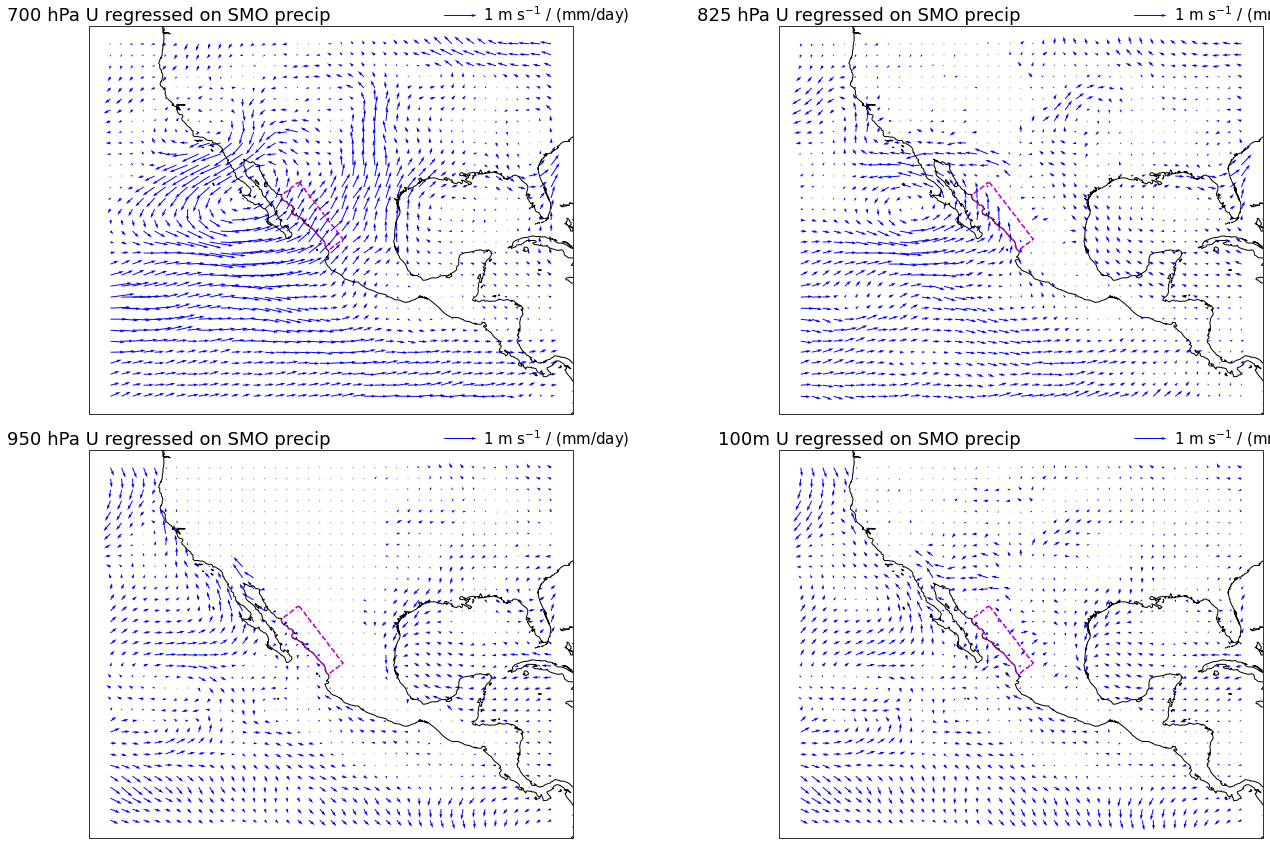

In [39]:
plot_u_reg(SMO.vars['U_YEARLY'],SMO.vars['V_YEARLY'],SMO.vars['VAR_100U_YEARLY'],SMO.vars['VAR_100V_YEARLY'],gpm_pr_summermonths_yearly,[700.,825.,950.])


## T,q,$\theta_{eB}$,...

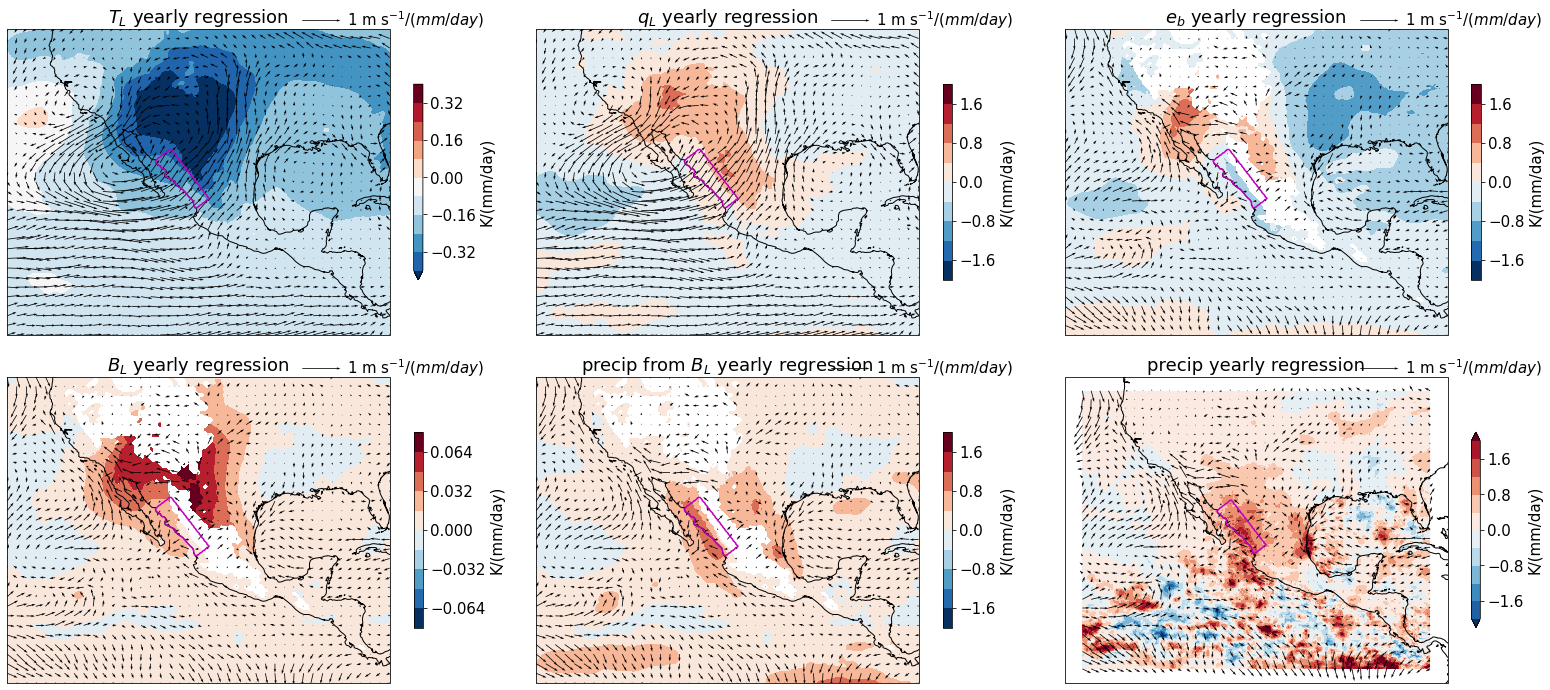

In [42]:

plot_tq_reg(SMO.vars['TL_YEARLY'],SMO.vars['QL_YEARLY'],SMO.vars['EB_YEARLY'],
            SMO.vars['BLSIMPLE_YEARLY'],SMO.vars['GPM_PR_YEARLY'],
            SMO.vars['UL_YEARLY'],SMO.vars['VL_YEARLY'],SMO.vars['VAR_100U_YEARLY'],SMO.vars['VAR_100V_YEARLY'],
            gpm_pr_summermonths_yearly)


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


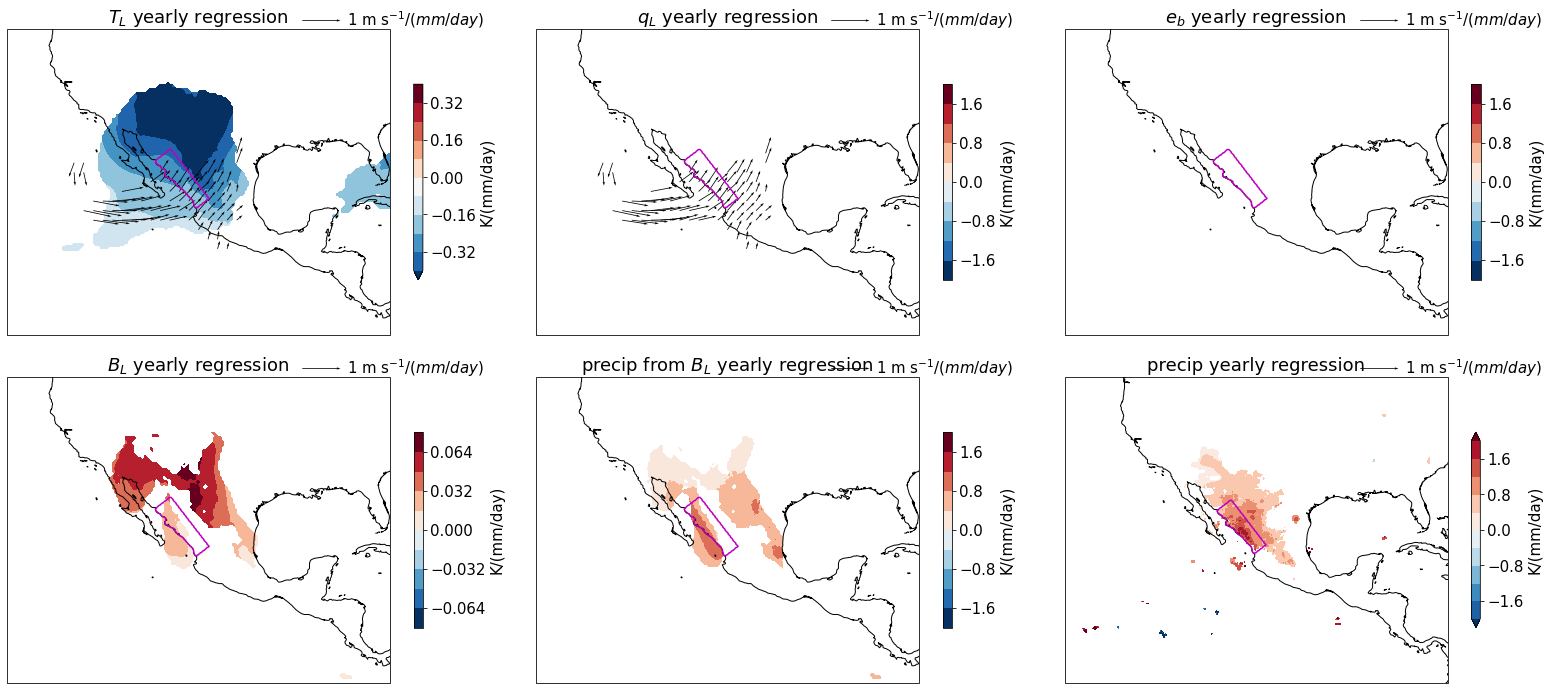

In [43]:
plot_tq_reg(SMO.vars['TL_YEARLY'],SMO.vars['QL_YEARLY'],SMO.vars['EB_YEARLY'],
            SMO.vars['BLSIMPLE_YEARLY'],SMO.vars['GPM_PR_YEARLY'],
            SMO.vars['UL_YEARLY'],SMO.vars['VL_YEARLY'],SMO.vars['VAR_100U_YEARLY'],SMO.vars['VAR_100V_YEARLY'],
            gpm_pr_summermonths_yearly,True)

## SST

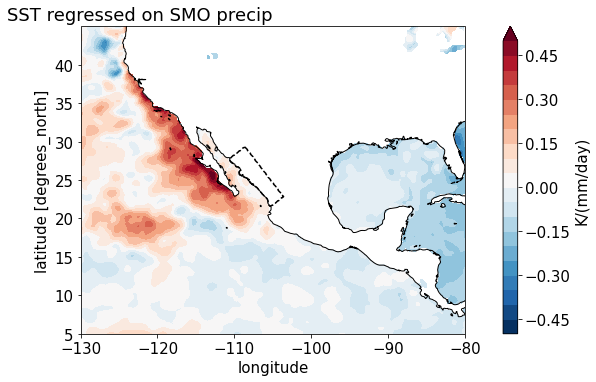

In [74]:
plot_sst_reg(sel_summer(SMO.vars['SST_3D']).groupby('time.year').mean('time'),gpm_pr_summermonths_yearly,pmask=False,dtrend=False)

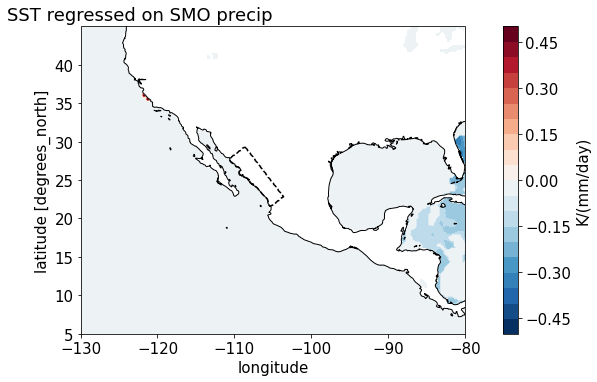

In [75]:
plot_sst_reg(sel_summer(SMO.vars['SST_3D']).groupby('time.year').mean('time'),gpm_pr_summermonths_yearly,pmask=True,dtrend=False)

# CRU regressions

In [27]:
cru_pr_allmonths    = spatial_mean( SMO.vars['CRU_PR_3D'],mask=SMO.precipmask).load()
cru_pr_summermonths = sel_summer(cru_pr_allmonths)
cru_pr_summermonths_yearly = cru_pr_summermonths.groupby('time.year').mean()

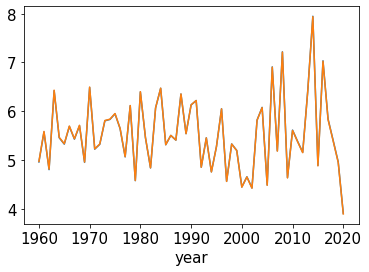

In [87]:
cru_pr_summermonths_yearly.plot()
(detrend(cru_pr_summermonths_yearly)+cru_pr_summermonths_yearly.mean()) .plot()

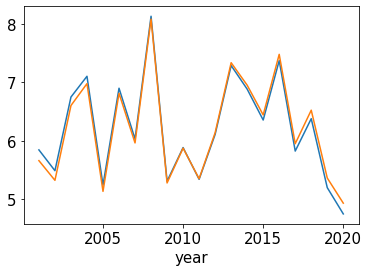

In [88]:
gpm_pr_summermonths_yearly.plot()
(detrend(gpm_pr_summermonths_yearly)+gpm_pr_summermonths_yearly.mean()) .plot()

## Wind

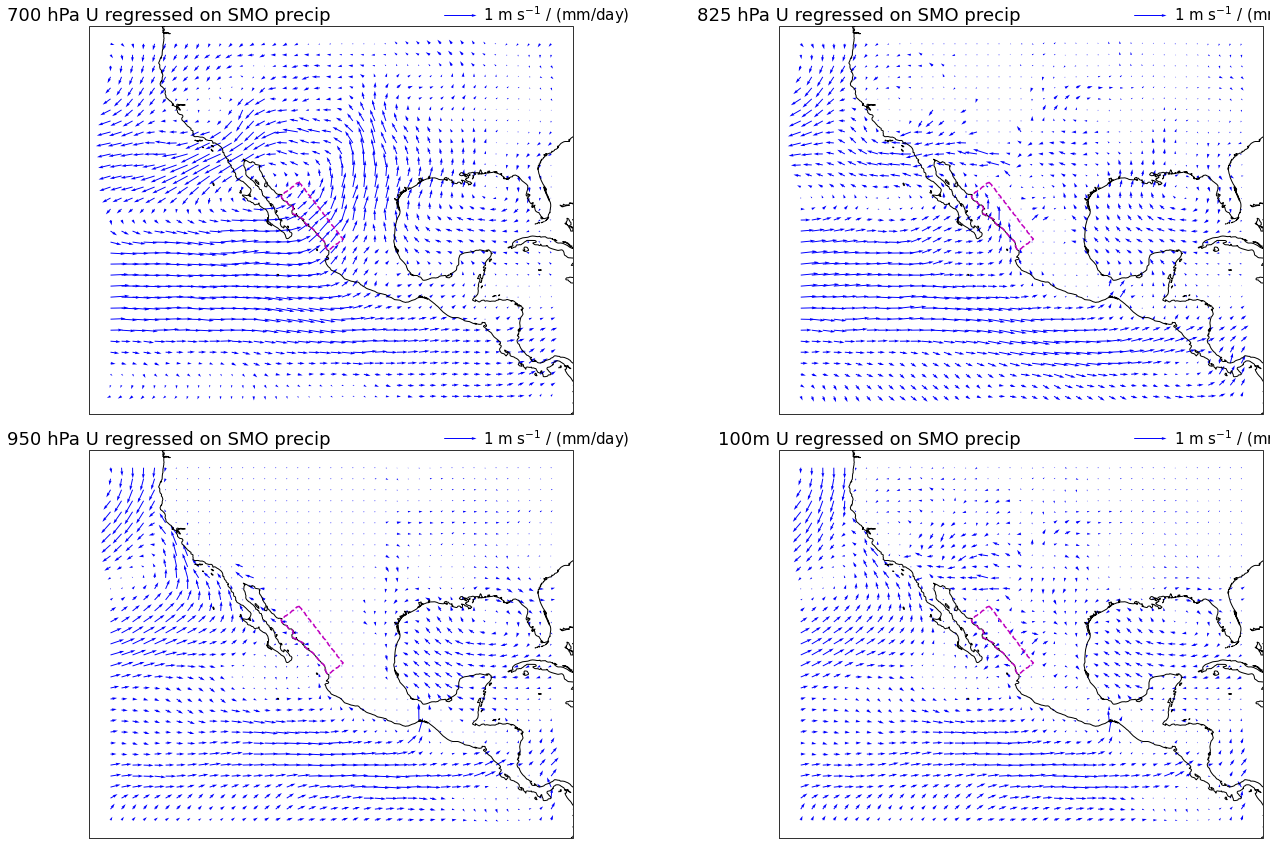

In [32]:
plot_u_reg(SMO.vars['U_YEARLY_LONG'],SMO.vars['V_YEARLY_LONG'],SMO.vars['VAR_100U_YEARLY_LONG'],SMO.vars['VAR_100V_YEARLY_LONG'],cru_pr_summermonths_yearly,[700.,825.,950.])


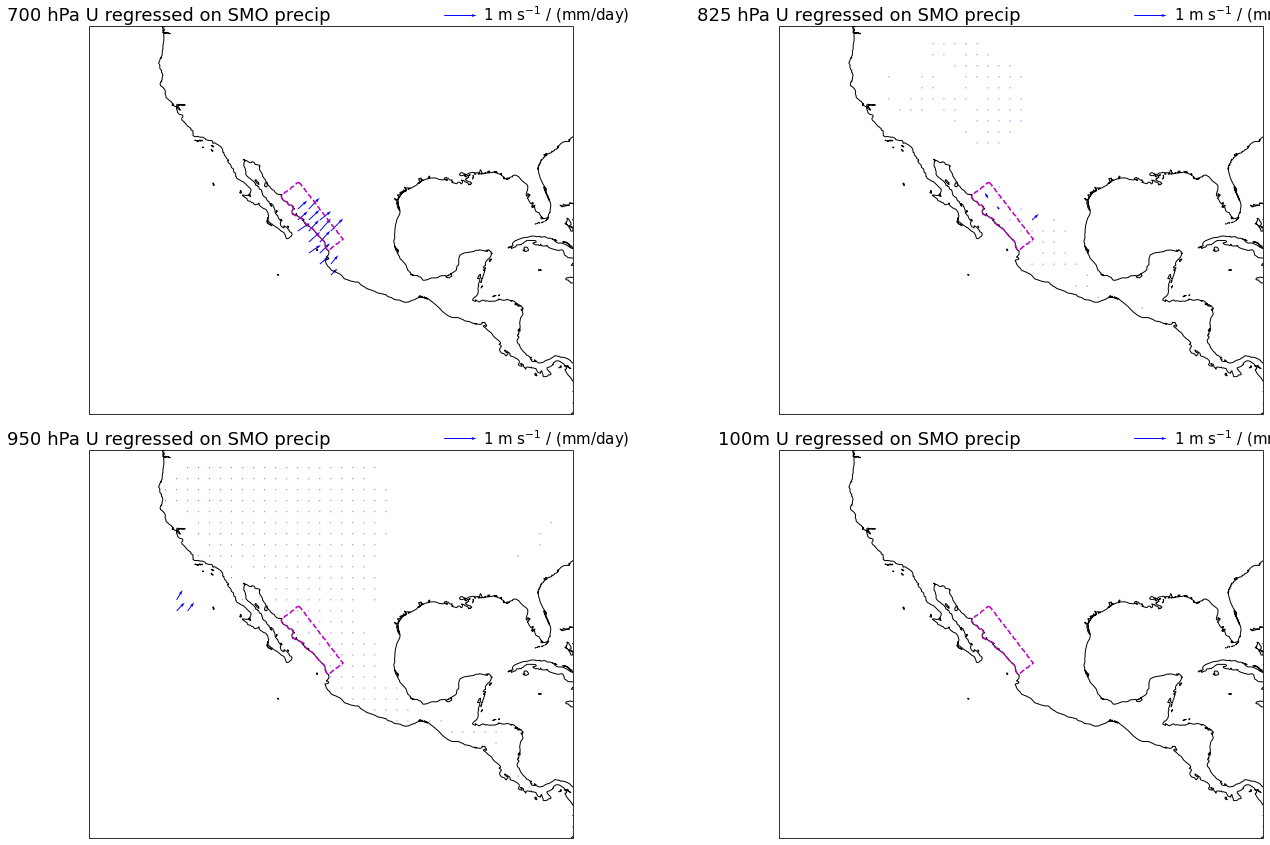

In [31]:
plot_u_reg(SMO.vars['U_YEARLY_LONG'],SMO.vars['V_YEARLY_LONG'],SMO.vars['VAR_100U_YEARLY_LONG'],SMO.vars['VAR_100V_YEARLY_LONG'],cru_pr_summermonths_yearly,[700.,825.,950.],True)


## T,q,$\theta_{eB}$,...

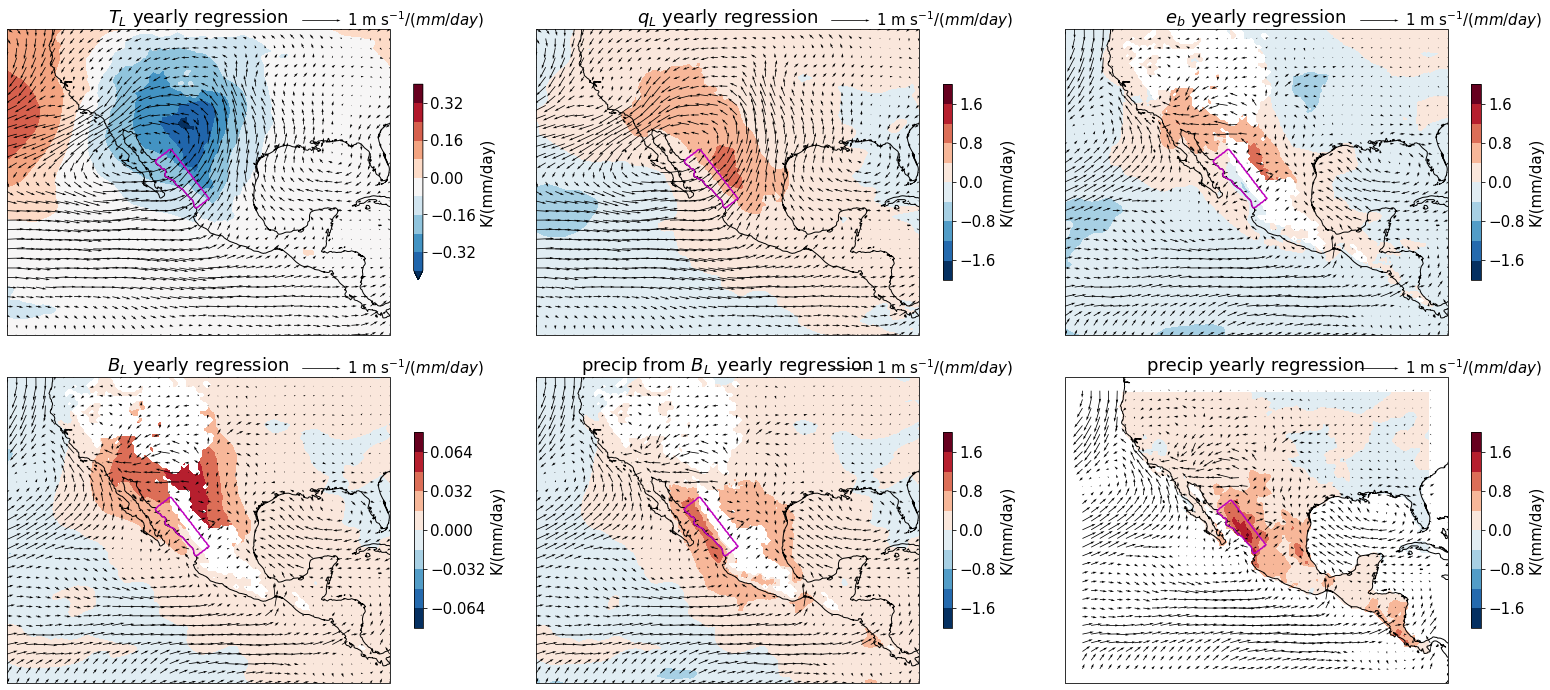

In [36]:

plot_tq_reg(SMO.vars['TL_YEARLY_LONG'],SMO.vars['QL_YEARLY_LONG'],SMO.vars['EB_YEARLY_LONG'],
            SMO.vars['BLSIMPLE_YEARLY_LONG'],SMO.vars['CRU_PR_YEARLY_LONG'],
            SMO.vars['UL_YEARLY_LONG'],SMO.vars['VL_YEARLY_LONG'],SMO.vars['VAR_100U_YEARLY_LONG'],SMO.vars['VAR_100V_YEARLY_LONG'],
            cru_pr_summermonths_yearly)


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


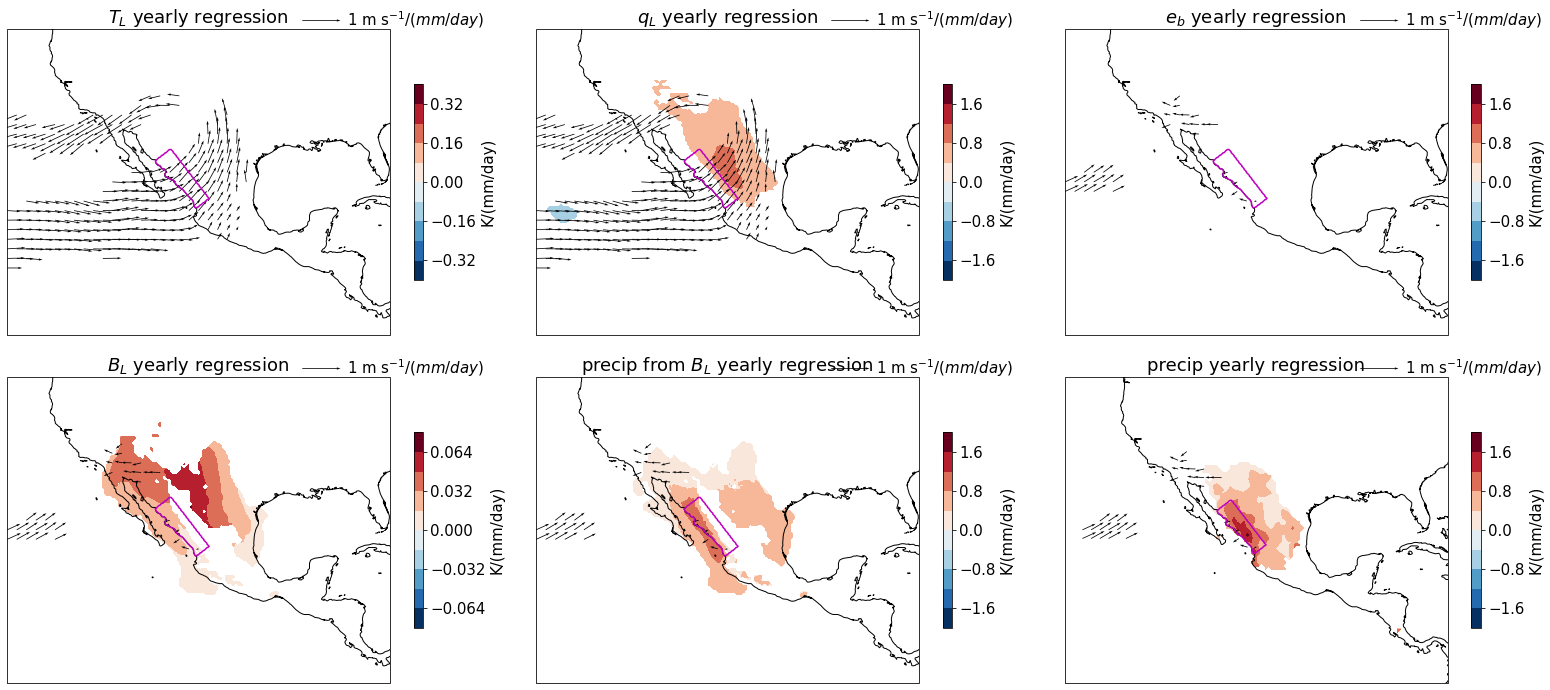

In [37]:

plot_tq_reg(SMO.vars['TL_YEARLY_LONG'],SMO.vars['QL_YEARLY_LONG'],SMO.vars['EB_YEARLY_LONG'],
            SMO.vars['BLSIMPLE_YEARLY_LONG'],SMO.vars['CRU_PR_YEARLY_LONG'],
            SMO.vars['UL_YEARLY_LONG'],SMO.vars['VL_YEARLY_LONG'],SMO.vars['VAR_100U_YEARLY_LONG'],SMO.vars['VAR_100V_YEARLY_LONG'],
            cru_pr_summermonths_yearly,True)


## SST

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


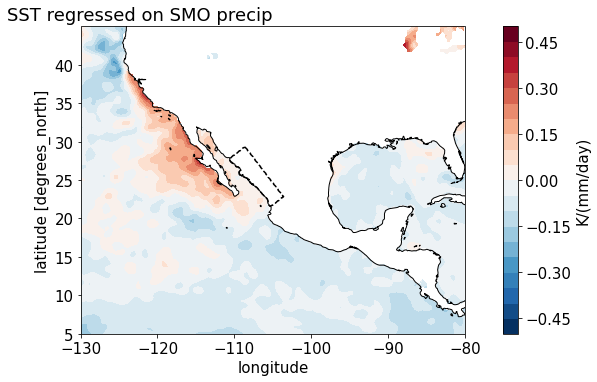

In [70]:
plot_sst_reg(sel_summer(SMO.vars['SST_3D_LONG']).groupby('time.year').mean('time'),cru_pr_summermonths_yearly,pmask=False,dtrend=False)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


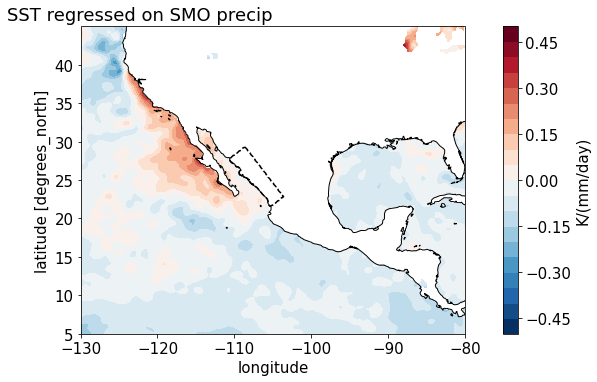

In [81]:
plot_sst_reg(sel_summer(SMO.vars['SST_3D_LONG']).groupby('time.year').mean('time'),cru_pr_summermonths_yearly,pmask=False,dtrend=True)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


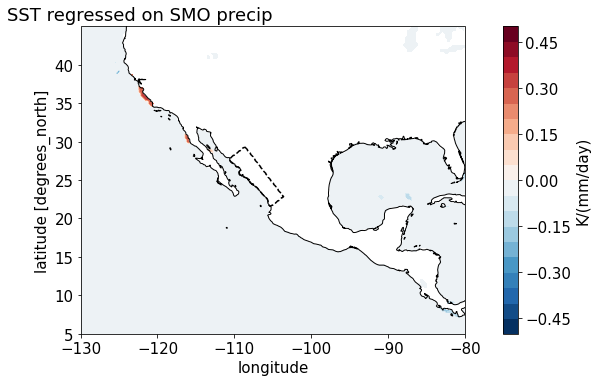

In [77]:
plot_sst_reg(sel_summer(SMO.vars['SST_3D_LONG']).groupby('time.year').mean('time'),cru_pr_summermonths_yearly,pmask=True,dtrend=True)

# ERA5 regressions

In [121]:
era5_pr_allmonths    = spatial_mean( SMO.vars['ERA5_PR_3D'],mask=SMO.precipmask).load()
era5_pr_summermonths = sel_summer(era5_pr_allmonths)
era5_pr_summermonths_yearly = era5_pr_summermonths.groupby('time.year').mean()

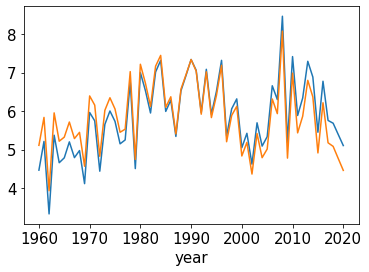

In [122]:
era5_pr_summermonths_yearly.plot()
(detrend(era5_pr_summermonths_yearly)+era5_pr_summermonths_yearly.mean()) .plot()

## Wind

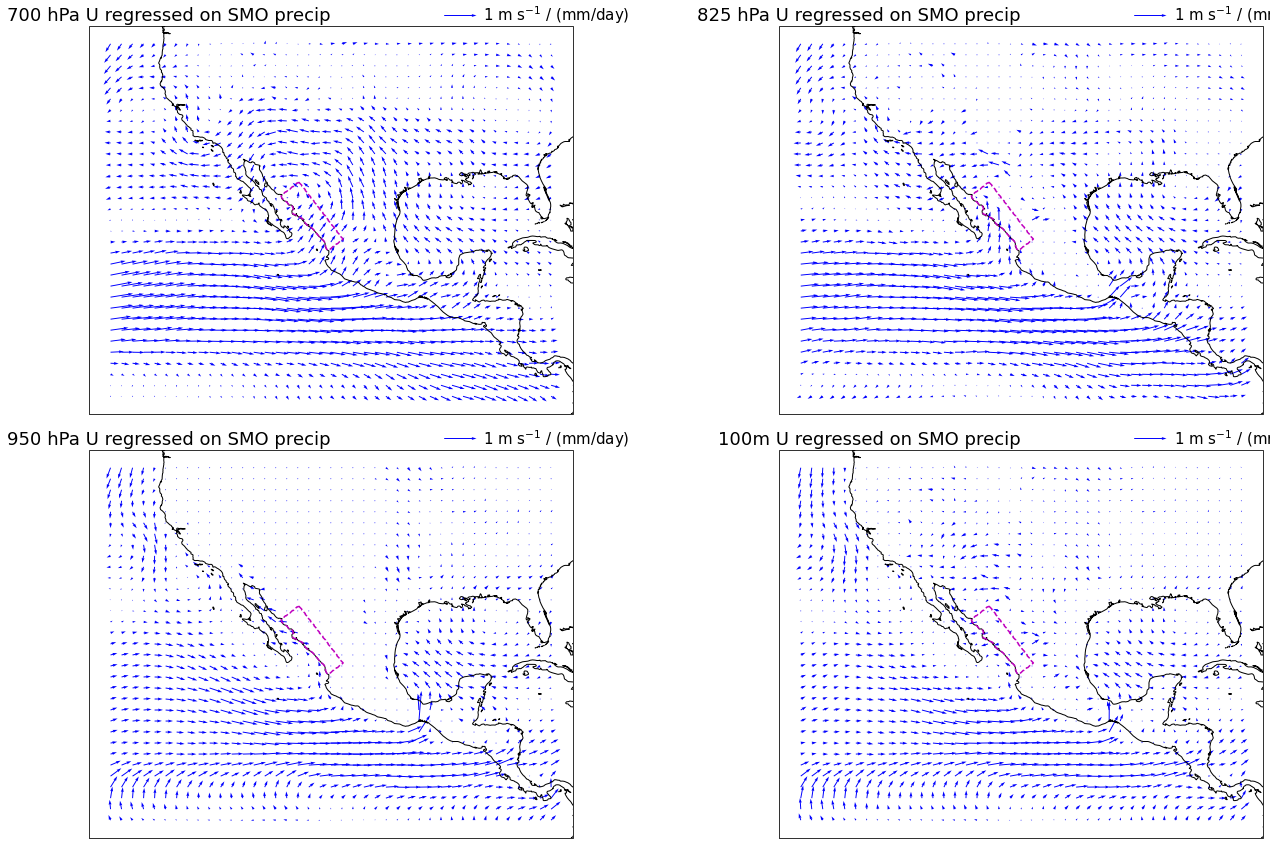

In [123]:
plot_u_reg(SMO.vars['U_YEARLY_LONG'] ,SMO.vars['V_YEARLY_LONG'] ,SMO.vars['VAR_100U_YEARLY_LONG'] ,SMO.vars['VAR_100V_YEARLY_LONG'] ,era5_pr_summermonths_yearly,[700.,825.,950.])


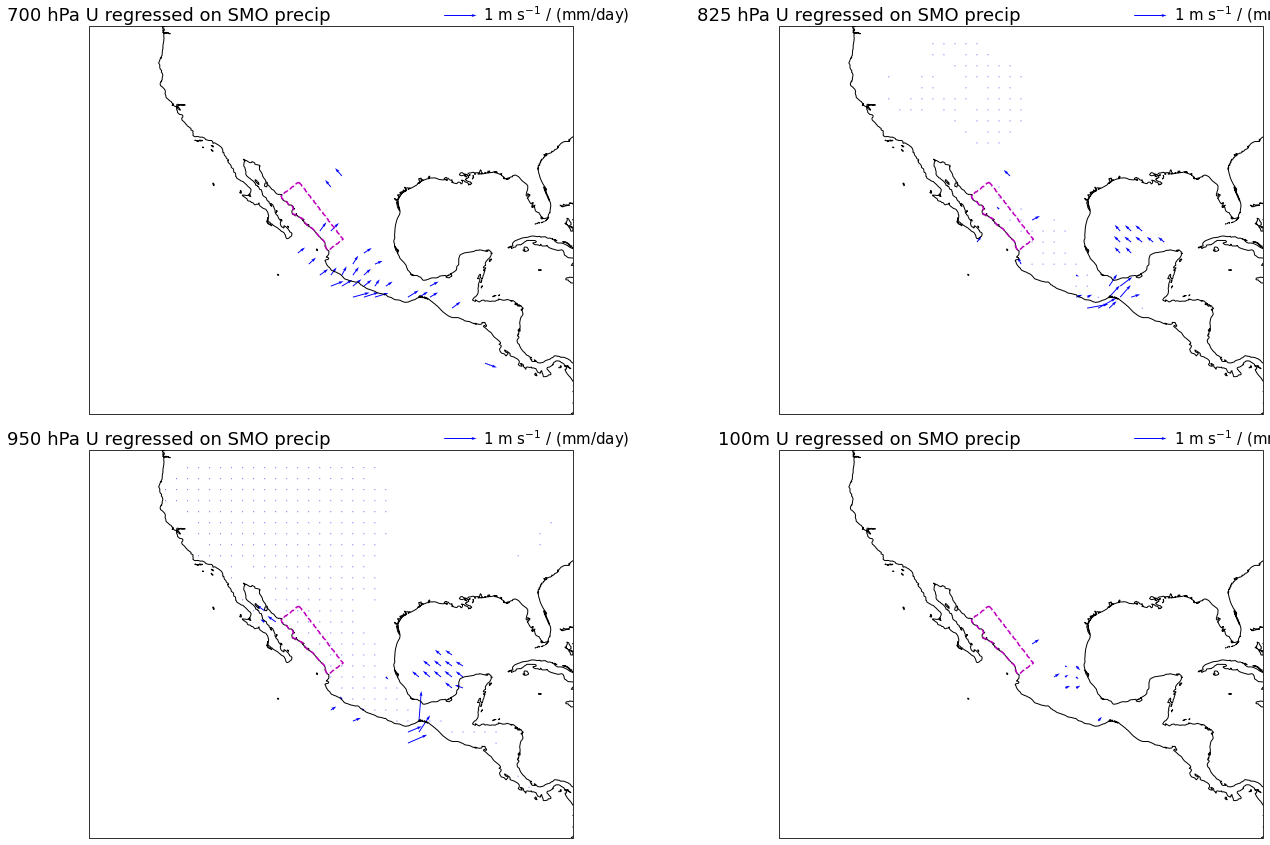

In [124]:
plot_u_reg(SMO.vars['U_YEARLY_LONG'] ,SMO.vars['V_YEARLY_LONG'] ,SMO.vars['VAR_100U_YEARLY_LONG'] ,SMO.vars['VAR_100V_YEARLY_LONG'] ,era5_pr_summermonths_yearly,[700.,825.,950.],fdr=True)


## T,q,$\theta_{eB}$,...

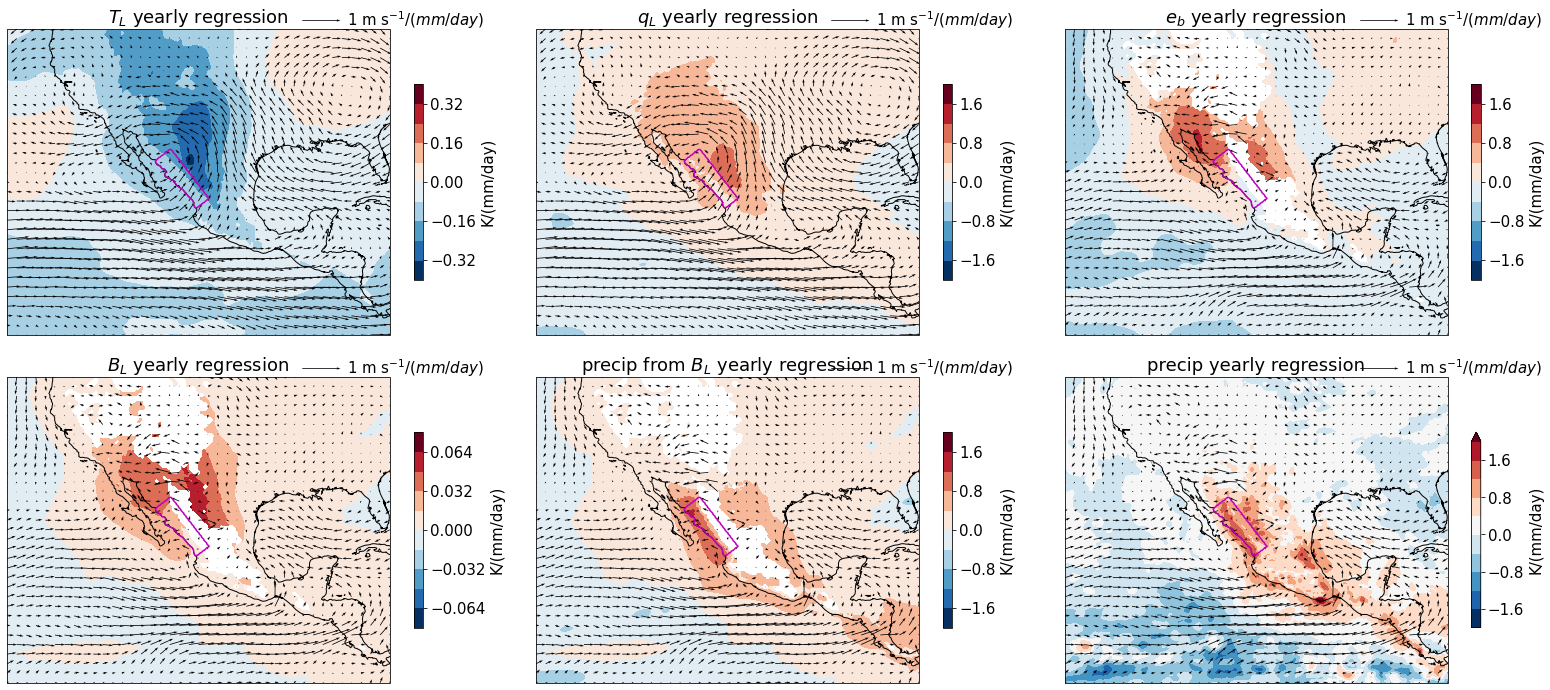

In [125]:

plot_tq_reg(SMO.vars['TL_YEARLY_LONG'] ,SMO.vars['QL_YEARLY_LONG'] ,SMO.vars['EB_YEARLY_LONG'] ,
            SMO.vars['BLSIMPLE_YEARLY_LONG'] ,SMO.vars['ERA5_PR_YEARLY_LONG'],
            SMO.vars['UL_YEARLY_LONG'] ,SMO.vars['VL_YEARLY_LONG'] ,SMO.vars['VAR_100U_YEARLY_LONG'] ,SMO.vars['VAR_100V_YEARLY_LONG'] ,
            era5_pr_summermonths_yearly,dtrend=True)


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


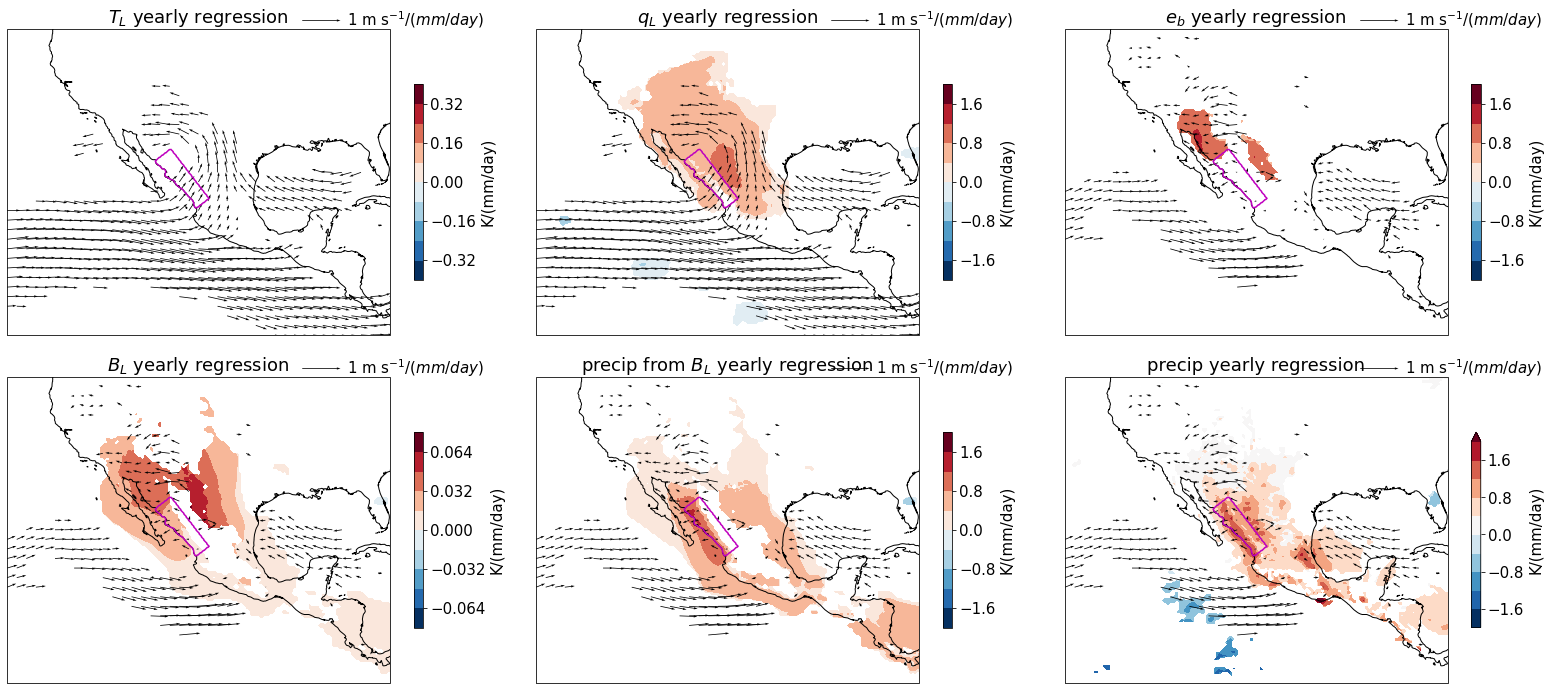

In [126]:

plot_tq_reg(SMO.vars['TL_YEARLY_LONG'] ,SMO.vars['QL_YEARLY_LONG'] ,SMO.vars['EB_YEARLY_LONG'] ,
            SMO.vars['BLSIMPLE_YEARLY_LONG'] ,SMO.vars['ERA5_PR_YEARLY_LONG'],
            SMO.vars['UL_YEARLY_LONG'] ,SMO.vars['VL_YEARLY_LONG'] ,SMO.vars['VAR_100U_YEARLY_LONG'] ,SMO.vars['VAR_100V_YEARLY_LONG'] ,
            era5_pr_summermonths_yearly,dtrend=True,fdr=True)


## SST

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


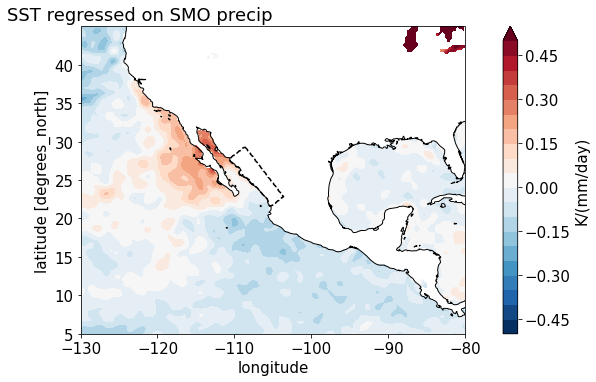

In [127]:
plot_sst_reg(sel_summer(SMO.vars['SST_3D_LONG']).groupby('time.year').mean('time') ,era5_pr_summermonths_yearly,pmask=False,dtrend=False)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


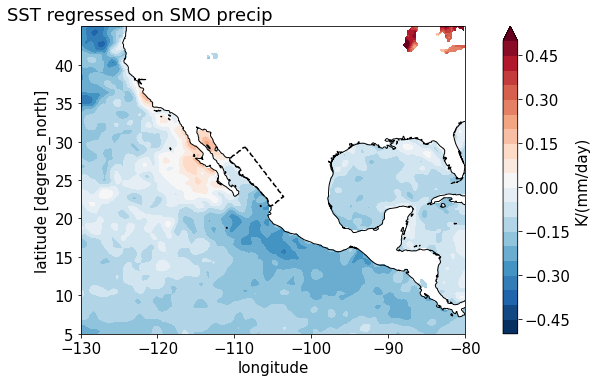

In [128]:
plot_sst_reg(sel_summer(SMO.vars['SST_3D_LONG']).groupby('time.year').mean('time') ,era5_pr_summermonths_yearly,pmask=False,dtrend=True)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


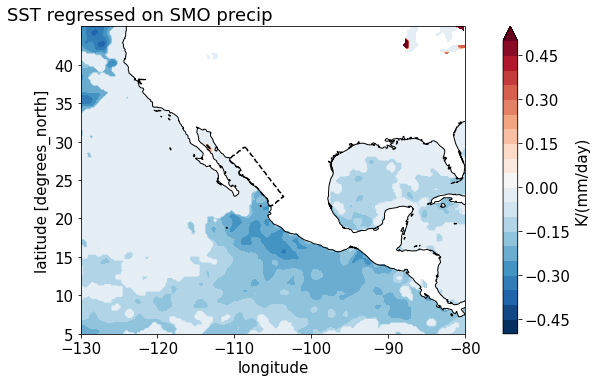

In [129]:
plot_sst_reg(sel_summer(SMO.vars['SST_3D_LONG']).groupby('time.year').mean('time') ,era5_pr_summermonths_yearly,pmask=True,dtrend=True)

# Comparing GPM and CRU regressions on a short record

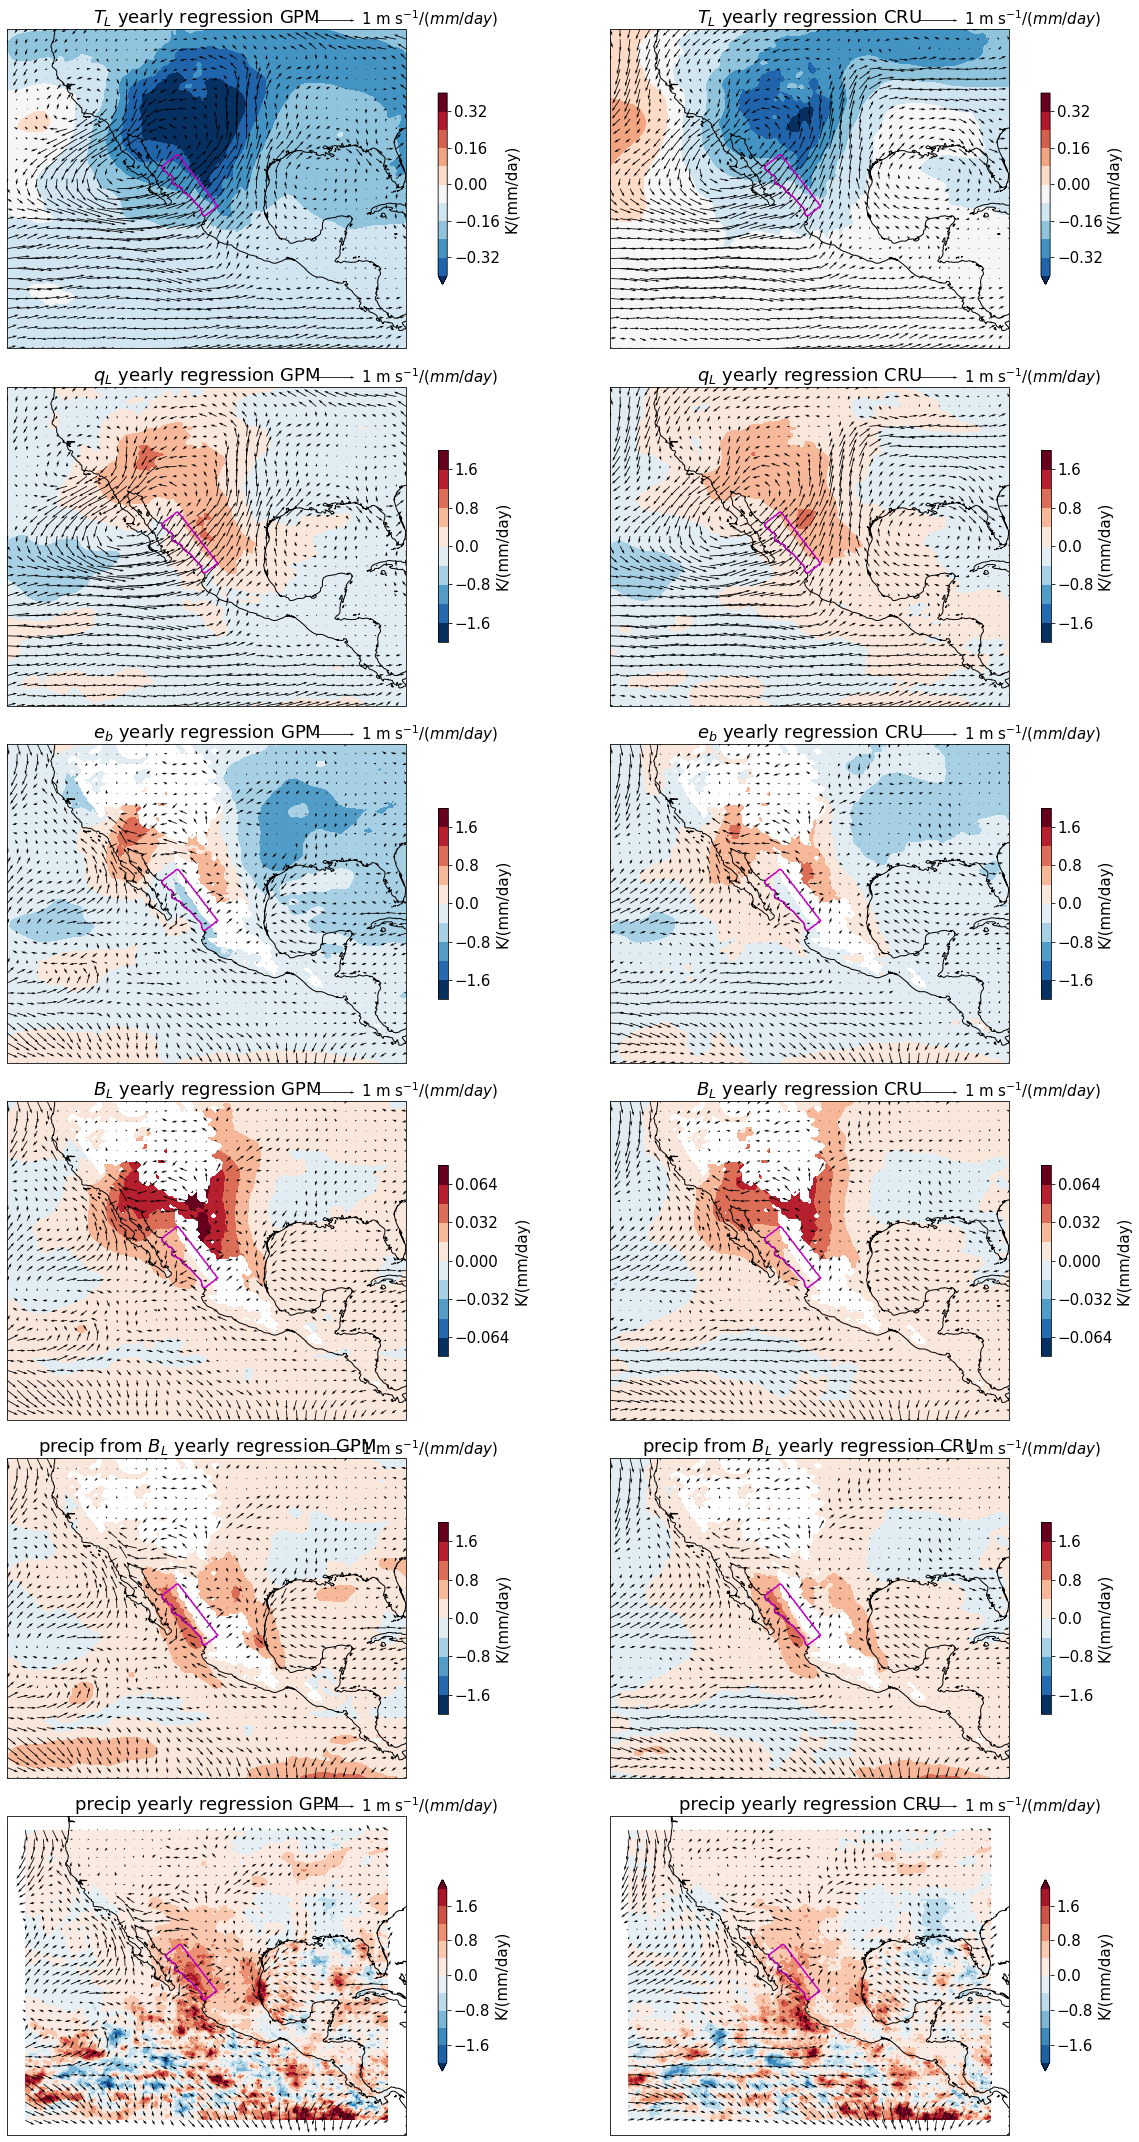

In [93]:
plot_tq_reg_compare(SMO.vars['TL_YEARLY'],SMO.vars['QL_YEARLY'],SMO.vars['EB_YEARLY'],
            SMO.vars['BLSIMPLE_YEARLY'],SMO.vars['GPM_PR_YEARLY'],
            SMO.vars['UL_YEARLY'],SMO.vars['VL_YEARLY'],SMO.vars['VAR_100U_YEARLY'],SMO.vars['VAR_100V_YEARLY'],
            gpm_pr_summermonths_yearly,cru_pr_summermonths_yearly[-20:],'GPM','CRU')


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matpl

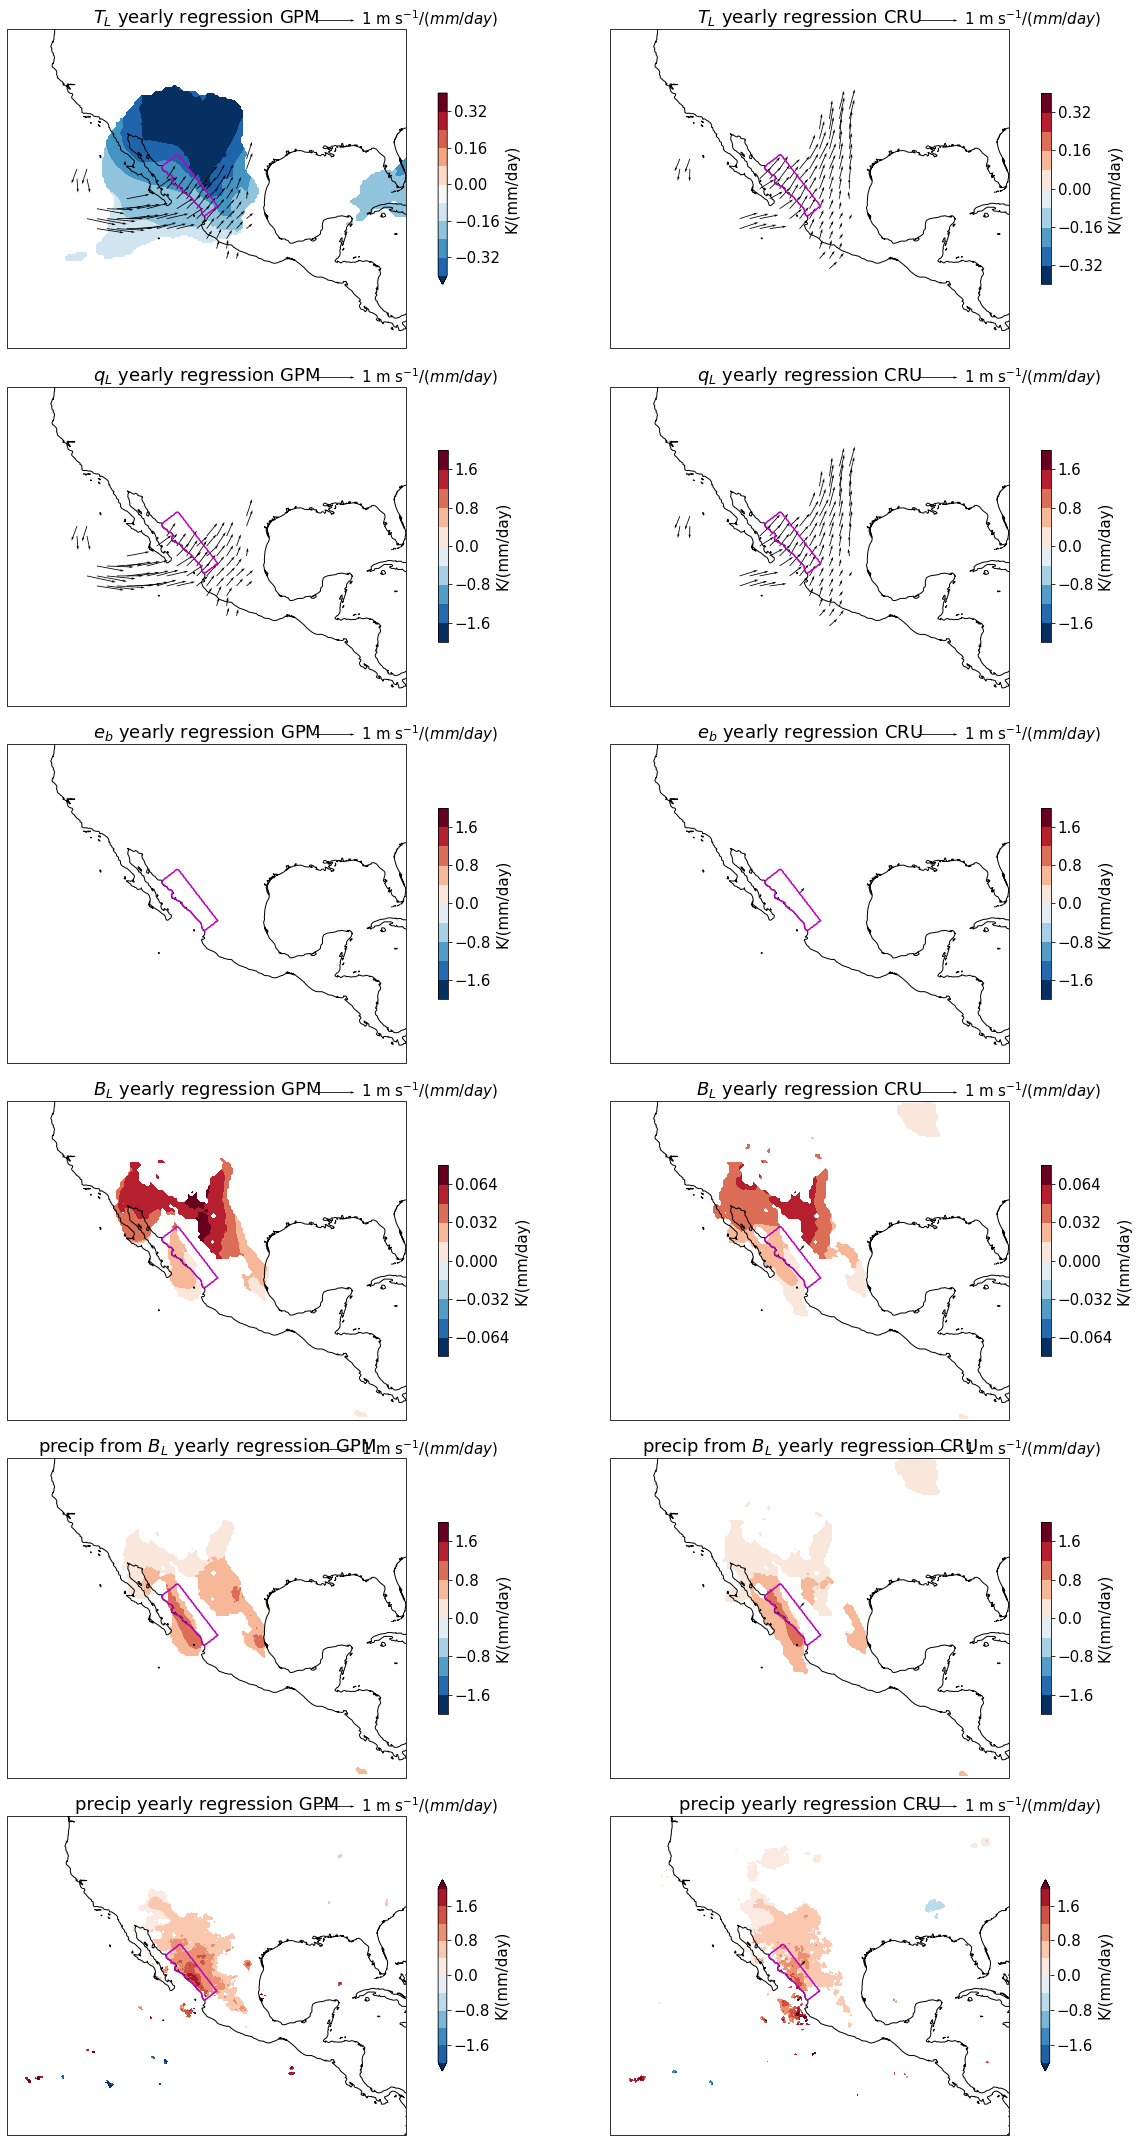

In [95]:
plot_tq_reg_compare(SMO.vars['TL_YEARLY'],SMO.vars['QL_YEARLY'],SMO.vars['EB_YEARLY'],
            SMO.vars['BLSIMPLE_YEARLY'],SMO.vars['GPM_PR_YEARLY'],
            SMO.vars['UL_YEARLY'],SMO.vars['VL_YEARLY'],SMO.vars['VAR_100U_YEARLY'],SMO.vars['VAR_100V_YEARLY'],
            gpm_pr_summermonths_yearly,cru_pr_summermonths_yearly[-20:],'GPM','CRU',fdr=True)


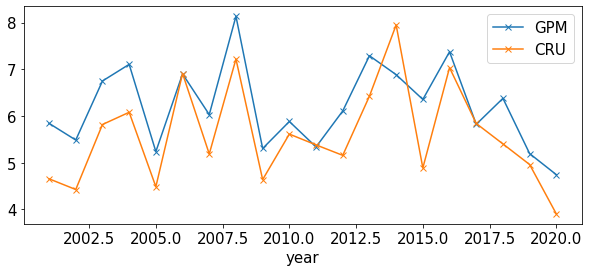

In [94]:
_,ax=plt.subplots(1,1,figsize=(10,4))
gpm_pr_summermonths_yearly.plot(ax=ax,marker='x',label='GPM')
cru_pr_summermonths_yearly[-20:].plot(ax=ax,marker='x',label='CRU')
ax.legend()